In [1]:
!pip install gradio pandas langchain langchain_community replicate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.6 MB/s eta 0:00:00


In [6]:
import gradio as gr
import pandas as pd
import os
from google.colab import userdata
from langchain_community.llms import Replicate
import matplotlib.pyplot as plt

api_token = userdata.get("api_token")
os.environ["REPLICATE_API_TOKEN"]= api_token

parameters = {
    "top_k": 5,
    "top_p": 1.0,
    "max_tokens": 4096,
    "temperature": 0.7,
}

llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    input=parameters,
)

df1 = pd.read_csv("/content/True.csv")
df2 = pd.read_csv("/content/Fake.csv")

fake_news = df1[['title']].copy()
fake_news['label'] = "Fake"
real_news = df2[['title']].copy()
real_news['label'] = "Real"
combined_df = pd.concat([fake_news, real_news], ignore_index=True)
combined_df = combined_df.drop_duplicates(subset=['title'])

def ask_question(question):
    context = combined_df.head(20).to_string(index=False)
    prompt = f"""
Berikut adalah sebagian isi data berita:
{context}

Pertanyaan: {question}

Jawaban berdasarkan data di atas:
"""
    result = llm.invoke(prompt)
    return result.strip()

def generate_insight_and_recommendation():
    context = combined_df.head(50).to_string(index=False)
    prompt = f"""
Berikut adalah data berita:
{context}

Dengan bantuan AI, lakukan analisis sebagai berikut:
1. Tampilkan hasil analisis data secara singkat (Analytical result).
2. Jelaskan insight atau temuan utama dari data (Insight & findings).
3. Berikan rekomendasi yang relevan (Recommendations).
"""
    result = llm.invoke(prompt)
    return result.strip()


def classify_and_summarize_all():
    results = []
    for title in combined_df['title'].dropna().head(10):
        try:
            prompt_classify = f"Classify the following news title as Fake or Real: {title[:400]}"
            classify_result = llm.invoke(prompt_classify).strip()
            prompt_summarize = f"Summarize the following news title in one short sentence: {title[:400]}"
            summarize_result = llm.invoke(prompt_summarize).strip()
            results.append({
                "Title": title,
                "Classification": classify_result,
                "Summary": summarize_result
            })
        except Exception as e:
            results.append({
                "Title": title,
                "Classification": "Error",
                "Summary": "Error"
            })
    return pd.DataFrame(results)

with gr.Blocks() as demo:
    gr.Markdown("### Analisis Berita Fake vs Real Menggunakan IBM Granite")

    with gr.Row():
        question_input = gr.Textbox(label="Pertanyaan", placeholder="Tulis pertanyaan Anda di sini...")
        answer_output = gr.Textbox(label="Jawaban")

    generate_button = gr.Button("Generate Insight & Recommendation")
    insight_output = gr.Textbox(label="Insight, Findings, and Recommendations")

    process_all_button = gr.Button("Proses Classify & Summarize Semua Data")
    result_table = gr.Dataframe(label="Hasil Classify & Summarize")

    question_input.submit(ask_question, inputs=[question_input], outputs=[answer_output])
    generate_button.click(generate_insight_and_recommendation, outputs=[insight_output])
    process_all_button.click(classify_and_summarize_all, outputs=result_table)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5282a2341450ede7ed.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


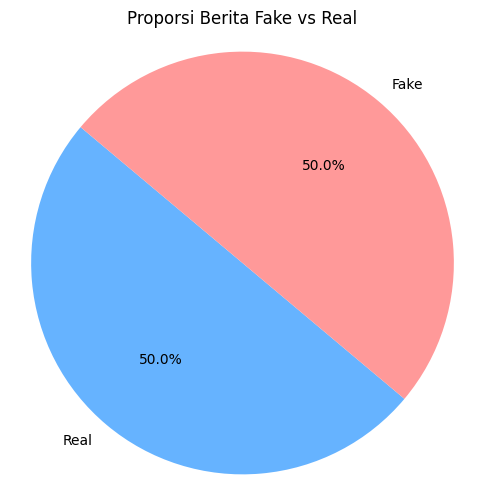

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df_real = pd.read_csv("/content/True.csv")
df_fake = pd.read_csv("/content/True.csv")

df_real["label"] = "Real"
df_fake["label"] = "Fake"

combined_df = pd.concat([df_real[["title", "label"]], df_fake[["title", "label"]]])

label_counts = combined_df["label"].value_counts()

plt.figure(figsize=(6, 6))
colors = ["#66b3ff", "#ff9999"]
plt.pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title("Proporsi Berita Fake vs Real")
plt.axis("equal")
plt.show()
